In [90]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
# from pandas_profiling import ProfileReport
import numpy as np
import warnings
import mlflow
import math 
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib import rc_params
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

ROOT = os.environ.get('PWD')

warnings.filterwarnings('ignore')






# Data cleaning and feature engineering

In [5]:
# read in new tiny master
new_tiny_master = pd.read_csv('../data//new_tiny_master.csv')

In [6]:
# extract the data for arrival date in 2019 only
tiny_master_19_20 = new_tiny_master.query("year == 2019 or year == 2020")

In [7]:
tiny_master_19_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117201 entries, 0 to 1117200
Data columns (total 86 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Unnamed: 0                      1117201 non-null  int64  
 1   listing_id                      1117201 non-null  object 
 2   yearmonth                       1117201 non-null  object 
 3   result_views                    1117201 non-null  float64
 4   expose_views                    1117201 non-null  float64
 5   year                            1117201 non-null  int64  
 6   month                           1117201 non-null  int64  
 7   1_room_apartment                1117201 non-null  float64
 8   dining_room                     1117201 non-null  float64
 9   en_suite_bathroom               1117201 non-null  float64
 10  kitchen                         1117201 non-null  float64
 11  kitchen_living                  1117201 non-null  float64
 12  

In [8]:
# We normalize x values to match with the 0-2π cycle
tiny_master_19_20["month_norm"] = 2 * math.pi * tiny_master_19_20["month"] / tiny_master_19_20["month"].max()

tiny_master_19_20["cos_month"] = np.cos(tiny_master_19_20["month_norm"])
tiny_master_19_20["sin_month"] = np.sin(tiny_master_19_20["month_norm"])

In [9]:
tiny_master_19_20["month_norm"]

0          0.523599
1          1.047198
2          6.283185
3          6.283185
4          0.523599
             ...   
1117196    6.283185
1117197    6.283185
1117198    5.235988
1117199    6.283185
1117200    6.283185
Name: month_norm, Length: 1117201, dtype: float64

In [10]:
tiny_master_19_20['price_per_day'] = tiny_master_19_20['inquiry_price']/tiny_master_19_20['length_stay']

In [11]:
# generate the feature inquiry_price_per_day, max_price_per_day, min_price_per_day

medium_master_price_agg = tiny_master_19_20.groupby(['listing_id','month']).agg(['mean','max','min'])['price_per_day'].reset_index()

In [12]:
medium_master_price_agg

,listing_id,month,mean,max,min
0,00005de7-6ed8-541b-be83-2573a46cd307,5,96.041667,98.333333,93.750000
1,00005de7-6ed8-541b-be83-2573a46cd307,6,89.727891,98.333333,87.857143
2,00005de7-6ed8-541b-be83-2573a46cd307,7,103.958333,104.583333,103.333333
3,00005de7-6ed8-541b-be83-2573a46cd307,8,103.668367,107.857143,92.857143
4,00005de7-6ed8-541b-be83-2573a46cd307,10,87.857143,87.857143,87.857143
...,...,...,...,...,...
198908,ffffa8d1-d94a-5475-8e0d-2057495f4734,7,80.669643,88.571429,35.714286
198909,ffffa8d1-d94a-5475-8e0d-2057495f4734,8,81.166667,88.571429,71.428571
198910,ffffa8d1-d94a-5475-8e0d-2057495f4734,9,63.345238,68.571429,59.000000
198911,ffffa8d1-d94a-5475-8e0d-2057495f4734,10,65.910293,68.571429,60.454545


In [13]:
medium_master_inquiry_count = tiny_master_19_20.groupby(['listing_id','month']).agg(['count'])['price_per_day'].reset_index()

In [14]:
medium_master_inquiry_count

,listing_id,month,count
0,00005de7-6ed8-541b-be83-2573a46cd307,5,2
1,00005de7-6ed8-541b-be83-2573a46cd307,6,7
2,00005de7-6ed8-541b-be83-2573a46cd307,7,2
3,00005de7-6ed8-541b-be83-2573a46cd307,8,7
4,00005de7-6ed8-541b-be83-2573a46cd307,10,1
...,...,...,...
198908,ffffa8d1-d94a-5475-8e0d-2057495f4734,7,8
198909,ffffa8d1-d94a-5475-8e0d-2057495f4734,8,6
198910,ffffa8d1-d94a-5475-8e0d-2057495f4734,9,6
198911,ffffa8d1-d94a-5475-8e0d-2057495f4734,10,9


In [15]:
medium_master_1 = pd.merge(medium_master_price_agg, tiny_master_19_20, left_on=['listing_id','month'], right_on=['listing_id','month'], how='right')

In [16]:
medium_master_1.drop('Unnamed: 0',axis=1,inplace=True)

In [17]:
medium_master_2 = pd.merge(medium_master_inquiry_count, medium_master_1, left_on=['listing_id','month'], right_on=['listing_id','month'], how='right')

In [18]:
medium_master_2.drop(['inquiry_price','month','month_norm','year','yearmonth'],axis=1,inplace=True)

In [19]:
medium_master_2.drop(['price_per_day'],axis=1,inplace=True)

In [20]:
medium_master_2.rename(columns={'count':'inquiry_count','mean':'mean_price_per_day','max':'max_price_per_day','min':'min_price_per_day'},inplace=True)

In [21]:
list(medium_master_2.columns.values)

['listing_id',
 'inquiry_count',
 'mean_price_per_day',
 'max_price_per_day',
 'min_price_per_day',
 'result_views',
 'expose_views',
 '1_room_apartment',
 'dining_room',
 'en_suite_bathroom',
 'kitchen',
 'kitchen_living',
 'living_bedroom',
 'living_/_dining_room',
 'living_room',
 'roof-deck',
 'separate_WC',
 'veranda',
 'additional_bed',
 'bathtub',
 'bed_linen',
 'bicycles',
 'coffee_machine',
 'computer',
 'double_bed',
 'fan',
 'fireplace',
 'freezer',
 'games',
 'garage',
 'garden_furniture',
 'hair_dryer',
 'hot_tub',
 'infrared_cabin',
 'kingsize_bed',
 'microwave',
 'pool_table',
 'private_parking',
 'radio',
 'refrigerator',
 'shower',
 'single_bed',
 'sofa_bed',
 'steam_bath',
 'tanning_bed',
 'cooking',
 'date',
 'adult_count',
 'children_count',
 'pets_count',
 'arrival_date',
 'departure_date',
 'length_stay',
 'subregion',
 'property_type',
 'option_allergic',
 'option_non_smoking_only',
 'option_holiday_with_your_pet',
 'option_holiday_with_your_horse',
 'option_holi

In [22]:
medium_master_2.drop(['date','arrival_date','departure_date','option_holiday_with_your_dog','option_holiday_with_your_horse'],axis=1,inplace=True)

In [23]:
# trying not to be a dummy by getting dummies
master_dummies = pd.get_dummies(medium_master_2, columns=['subregion','property_type'])

In [24]:
# save csv for this data set
"""master_dummies.to_csv('../data/master_with_dummies_19_20.csv')"""

"master_dummies.to_csv('../data/master_with_dummies_19_20.csv')"

In [25]:
master_dummies

,listing_id,inquiry_count,mean_price_per_day,max_price_per_day,min_price_per_day,result_views,expose_views,1_room_apartment,dining_room,en_suite_bathroom,...,subregion_Westerzgebirge,subregion_Westheide,subregion_Willingen,subregion_Zeller Land,subregion_Zugspitz-Region,subregion_Überlinger See,property_type_apartment,property_type_bungalow,property_type_holiday_apartment,property_type_holiday_houses
0,97232bc1-cee6-54cc-9965-be13177051d3,10,76.580000,115.000000,57.000000,2468.0,977.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,97232bc1-cee6-54cc-9965-be13177051d3,18,76.761905,81.000000,74.000000,2930.0,1051.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,97232bc1-cee6-54cc-9965-be13177051d3,31,121.182258,142.000000,55.000000,2183.0,512.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,97232bc1-cee6-54cc-9965-be13177051d3,31,121.182258,142.000000,55.000000,2183.0,512.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,97232bc1-cee6-54cc-9965-be13177051d3,10,76.580000,115.000000,57.000000,2468.0,977.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117196,bd2737ac-54e2-5045-8706-bf0aef99456e,4,85.250000,94.000000,79.000000,344.0,83.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1117197,bd2737ac-54e2-5045-8706-bf0aef99456e,4,85.250000,94.000000,79.000000,344.0,83.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1117198,00779d9d-7264-5704-a71d-e6d1849cb4b7,1,133.333333,133.333333,133.333333,1239.0,180.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1117199,00779d9d-7264-5704-a71d-e6d1849cb4b7,1,140.000000,140.000000,140.000000,363.0,11.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
X = master_dummies.drop(['listing_id','inquiry_count'],axis=1)
Y = master_dummies['inquiry_count']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [28]:
the_list = ['result_views','expose_views','adult_count','children_count','pets_count','length_stay','bathrooms','bedrooms','max_guests','living_area']

In [29]:
# Scaling with MinMaxScaler
scaler_norm = MinMaxScaler()
X_train_scaled_norm = scaler_norm.fit_transform(X_train[the_list])
X_test_scaled_norm = scaler_norm.transform(X_test[the_list])

In [30]:
# Concatenating normalized columns 
X_train_preprocessed_norm = np.concatenate([X_train_scaled_norm, X_train.drop(the_list, axis=1)], axis=1)
X_test_preprocessed_norm = np.concatenate([X_test_scaled_norm, X_test.drop(the_list, axis=1)], axis=1)

In [31]:
X_train_preprocessed_norm.shape

(782040, 274)

In [32]:
X_test_preprocessed_norm.shape

(335161, 274)

## Trainining the model and tracking with MLFlow

In [33]:
# setting the MLFlow connection and experiment
"""mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()"""

'mlflow.set_tracking_uri(TRACKING_URI)\nmlflow.set_experiment(EXPERIMENT_NAME)\nmlflow.start_run()\nrun = mlflow.active_run()'

In [ ]:
print("Active run_id: {}".format(run.info.run_id))

In [35]:
master_dummies.isna().sum()

listing_id                         0
inquiry_count                      0
mean_price_per_day                 0
max_price_per_day                  0
min_price_per_day                  0
                                  ..
subregion_Überlinger See           0
property_type_apartment            0
property_type_bungalow             0
property_type_holiday_apartment    0
property_type_holiday_houses       0
Length: 276, dtype: int64

In [36]:
#training the model
reg1 = LinearRegression().fit(X_train_preprocessed_norm, y_train)

In [76]:
y_train_pred = reg1.predict(X_train_preprocessed_norm)
rmse_train = mean_squared_error(y_train, y_train_pred,squared=False)
r2_train = r2_score(y_train, y_train_pred)
print(rmse_train)
print(r2_train)


54.13583910847331
0.6136130052970447


In [38]:
y_test_pred = reg1.predict(X_test_preprocessed_norm)
rmse_test = mean_squared_error(y_test, y_test_pred,squared=False)
r2_test = r2_score(y_test, y_test_pred)
print(rmse_test)
print(r2_test)

53.77252341484805
0.6101562352787913


In [39]:
mean_absolute_error(y_test, y_test_pred)

27.340102412747644

In [68]:
print(cross_val_score(reg1, X, Y, cv=10, scoring='r2').mean())

0.4570549862038587


In [94]:
y_residual = y_test - y_test_pred

In [ ]:
"""#Plot Our Actual and Predicted Values
plt.plot(y_test, label="Residual")
plt.plot(y_test_pred)
plt.xlabel('Predicted')
plt.ylabel("Residual")
plt.grid(True)
plt.show"""

sns.scatterplot(x=X_train, y=y_rep, )

In [53]:
plt.rcParams['agg.path.chunksize'] = 10000

SyntaxError: invalid syntax (4276875615.py, line 1)

<AxesSubplot:xlabel='inquiry_count'>

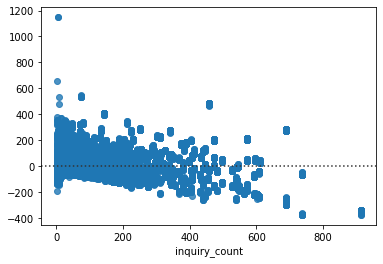

In [111]:
sns.residplot(x=y_test, y=y_test_pred)

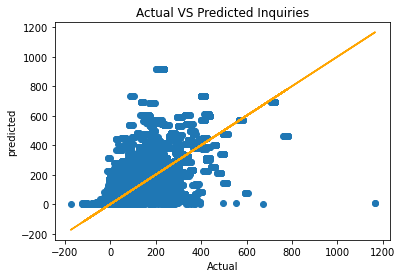

In [117]:

plt.scatter(y=y_test, x=y_test_pred)
plt.plot(y_test_pred, y_test_pred, color='orange')
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title(f'Actual VS Predicted Inquiries')
plt.show()


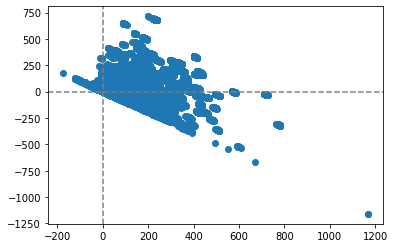

In [119]:
plt.axhline(0, c=(.5, .5, .5), ls='--')
plt.axvline(0, c=(.5, .5, .5), ls='--')
plt.scatter(x=y_test_pred, y=y_residual)

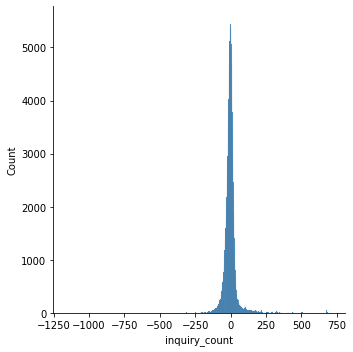

In [82]:
sns.displot(y_residual)

In [ ]:
params = {
      "train_test_split": 30,
      "normalized data": 'yes',
      "2019 and 2020 data": "2019 and 2020 data", 
      "metric": 'rmse', 'r2'
      "cross_val_score": "yes", "no"
  }

In [ ]:
"""mlflow.log_params(params)
mlflow.set_tag("running_from_jupyter", "baseline model 2019")
mlflow.log_metric("train -" + "RMSE", rmse_train)
mlflow.log_metric("test -" + "RMSE", rmse_test)
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()"""

In [ ]:
"""mlflow.get_run(run_id=run.info.run_id)"""

## Checking the experiments

while the next cell is running you will not be able to run other cells in the notebook

In [ ]:
#!mlflow ui